In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Installing Required Libraries 

In [2]:
# Installing necessary libraries 
!pip3 install -U scikit-learn
!pip3 install pandas
!pip install matplotlib==3.1.1
!pip install xgboost==1.0.0
!pip install shap
!pip install lime
!pip install scikit-learn-extra
!pip install graphviz
!pip install anchor_exp
!pip install networkx
!pip install orderedset
!pip install gensim

     |████████████████████████████████| 22.3MB 1.3MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 13.1MB 5.8MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


     |████████████████████████████████| 109.8MB 89kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
     |████████████████████████████████| 358kB 4.1MB/s 
  Created wheel for shap: filename=shap-0.38.1-cp37-cp37m-linux_x86_64.whl size=490490 sha256=0eb58fb9678705b29af9f91998f0a8e3e9741798eeb152e5d0132d9c08c6283d
  Stored in directory: /root/.cache/pip/wheels/a8/fb/e4/88012be41842b9be62ae18d82d1b1e880daf8539d1fef1fa00
Successfully built shap
     |████████████████████████████████| 276kB 4.5MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=80dbf05d11a5798c77b8ad54fb8f4728f76ca3efda891737fd32f448c8e868d0
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime
     |████████████████████████████████| 624kB 4.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
 

# Import Libraries

In [3]:
# -*- coding: utf-8 -*-

import re
import os.path
from collections import OrderedDict
from collections import defaultdict
import sys
from functools import reduce
import collections
from sklearn.utils import shuffle

import lime
import lime.lime_tabular
from anchor import anchor_tabular

import sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from ipywidgets import IntProgress
from IPython.display import display, HTML

from sklearn.tree import export_graphviz
from sklearn import tree
from xgboost import plot_tree
import networkx as nx
from matplotlib.lines import Line2D

import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn import manifold
import matplotlib.pyplot as plt
from orderedset import OrderedSet
from gensim.models import Word2Vec

from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
import functools
from sklearn.preprocessing import MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

import xgboost as xgb

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

from xaiMethod import Explainer

# PLOTLY AND DASH Libraries


shap.initjs()



# Training and Testing the Random Forest, and Running Explanation Methods

In [15]:
# -*- coding: utf-8 -*-
   
# Main Method for Training/Testing and Providing Explanations
def rf_ml_english(rand_seed, final_model, random_option, customer_index, index_vec, X_train, X_test, y_train, y_test, y_test_score, X_train_leg, X_train_fraud, X_train_leg_original, X_test_original, dataset_full):

    # Set random seed for current experiment 
    np.random.seed(rand_seed)
    model_name = final_model
    
    total_cases = 10 # Total Cases for Case-based explanations    

    if final_model == "rf":
      model = RandomForestClassifier(bootstrap=True,max_depth=None,max_features='auto',
                                    min_samples_leaf=1,min_samples_split=2,
                                    n_estimators=100)
    elif final_model == "mlp":
      model = MLPClassifier(random_state=1, max_iter=500, activation='logistic')
    
    
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division = 1)
    rec = recall_score(y_test, y_pred)
    fscore = f1_score(y_test, y_pred)

    
    feature_names = list(X_train)
    total_feats_available = len(feature_names)
    
    categorical_features = list(range(4,len(feature_names)))
   

    categorical_features_anchors = [(index_, ["0","1"]) for index_ in list(range(4,len(feature_names)))]
    

    categorical_features_anchors_dict = OrderedDict(categorical_features_anchors)

    labels = y_train
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(labels)
    labels = le.transform(labels)
    class_names = le.classes_
    class_names_anchors = ["0", "1"]

    # BEGIN LIME SET UP
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train.to_numpy(),
                                                       feature_names=feature_names,
                                                       class_names=class_names,
                                                        categorical_features=categorical_features,
                                                       discretize_continuous=True)

    
    
    num_features_explain_LIME = 10
    
    # ANCHORS SET UP
    explainer_anchors = anchor_tabular.AnchorTabularExplainer(
    class_names,
    feature_names,
    X_train.to_numpy(),
    categorical_features_anchors_dict)
    
    
    # SHAP SET UP
    xai_methods = ["kmedoid_prototype", "kmedoid_criticism", "similar_case", "similar_case_all", "dissimilar_case", "force_plot", "shap_summary_plot"] # TODO - XML settings
    
    shap.initjs()
    
    xai_method = Explainer()
    xai_method.set_explanations(model_name, model, X_train, X_test, y_train, y_test, X_train_leg, X_train_fraud)
        
    
    
    
    """ -------- LOOP STARTS HERE --------- """
    for index_final_cust in index_vec:
        
        index = index_final_cust # Index of Transaction to Explain
        model_prediction = model.predict_proba(X_test.to_numpy()[index].reshape(1, -1)) 
        index_to_check_switching_point = np.argmax(model_prediction[0])
        true_label = 0 if y_test_score.iloc[index] < 0 else 1

        if index_to_check_switching_point != true_label: 
          continue
        
        dict_confidences = collections.OrderedDict()
        dict_confidences['rand_seed'] = rand_seed
        dict_confidences['customer_index'] = customer_index
        
        
        dict_confidences['transaction_index'] = index

        
        print('Prediction: ', model_prediction)
        dict_confidences['conf_model_leg'] = model_prediction[0][0]
        dict_confidences['conf_model_fraud'] = model_prediction[0][1]

        dict_confidences['random_eval'] = random_option
        
        
        print("index_to_check_switching_point: ", index_to_check_switching_point)
        
        top_features_lime = []
        conf_computed_lime = False

        X_test_temp = X_test.copy(deep=True)
        

        np.random.seed(1)
        exp = lime_explainer.explain_instance(X_test.iloc[index, :], model.predict_proba,
                                              num_features=total_feats_available)
        print("a) Local Feature Importance")
        exp.show_in_notebook(show_all=False)

        # Binary features: CHANNEL, CURR, RECV_LOC, SEND_LOC 
        # dataset_full
        changed_feats = []
        total_features = len(list(X_test))
        total_seen_feats_lime = num_features_explain_LIME

        lime_user_conf = 0
        lime_count_feats_passed = 0
        
        all_exp_features_to_count_top = exp.as_list()[:num_features_explain_LIME]

        

        
        for lime_feat in all_exp_features_to_count_top:
            lime_rule_str = lime_feat[0]
            
            res1 = re.findall(r"(AMOUNT_EUR|AMOUNT|DIST_TO_PREVIOUS|DIFF_AVG_DIST|AVG_AMOUNT|DIFF_AVG_AMOUNT)",
                          lime_rule_str)
            if len(res1) > 0:
                top_features_lime.append(res1[0])
            else:
                res2 = lime_rule_str.split("=")
                top_features_lime.append(res2[0])
       
        
        
        all_exp_features = exp.as_list()#[:num_features_explain_LIME]


        final_exp_features_NEGG = [feat for feat in all_exp_features if feat[1] < 0]
        final_exp_features_POSS = [feat for feat in all_exp_features if feat[1] > 0]




        if index_to_check_switching_point == 0:
            print("checking neg exlanations")
            final_exp_features = final_exp_features_NEGG
        elif index_to_check_switching_point == 1:
            print("checking pos exlanations")
            final_exp_features = final_exp_features_POSS

        
        
        print("final_exp_features")
        print(final_exp_features)
        
        # RANDOM OPTION
        if random_option == True:
          final_exp_features_random = final_exp_features[:]
          final_exp_features_random = shuffle(final_exp_features_random, random_state=rand_seed)
          final_exp_features = final_exp_features_random
          
        for lime_feat in final_exp_features[:num_features_explain_LIME]:
            lime_rule_str = lime_feat[0]

            if 'SEND' in lime_rule_str:
                #print("SEND detected")

                lime_feat_str, lime_feat_value = lime_rule_str.split("=")
                lime_feat_value = int(lime_feat_value)

                old_feat_to_change = dataset_full.iloc[index, dataset_full.columns.get_loc("SEND_LOC")]                
                
                if lime_feat_value == 0:
                    
                    
                    X_test_temp.iloc[index, X_test_temp.columns.get_loc(lime_feat_str)] = 1
                    X_test_temp.iloc[index, X_test_temp.columns.get_loc(old_feat_to_change)] = 0
                elif lime_feat_value == 1:
                    X_test_temp.iloc[index, X_test_temp.columns.get_loc(lime_feat_str)] = 0
                    X_test_temp.iloc[index, X_test_temp.columns.get_loc(old_feat_to_change)] = 1
                    
                
                lime_count_feats_passed += 1
                
                lime_pred_prob = model.predict_proba(X_test_temp.to_numpy()[index].reshape(1, -1))[0] 
                curr_max_index_pred = np.argmax(lime_pred_prob)
                
                #print("current lime pred_prob: ", lime_pred_prob)
                if (curr_max_index_pred != index_to_check_switching_point) and (conf_computed_lime == False):
                    #lime_user_conf = 1 - (lime_count_feats_passed / total_features)
                    lime_user_conf = (lime_count_feats_passed / total_seen_feats_lime)
                    conf_computed_lime = True

            if 'CHANNEL' in lime_rule_str:
                
                
                #print("CHANNEL detected")
                changed_feats.append('CHANNEL')
                lime_feat_str, lime_feat_value = lime_rule_str.split("=")
                lime_feat_value = int(lime_feat_value)

                old_feat_to_change = dataset_full.iloc[index, dataset_full.columns.get_loc("CHANNEL")]

                if lime_feat_value == 0:
                    X_test_temp.iloc[index, X_test_temp.columns.get_loc(lime_feat_str)] = 1
                    X_test_temp.iloc[index, X_test_temp.columns.get_loc(old_feat_to_change)] = 0
                elif lime_feat_value == 1:
                    X_test_temp.iloc[index, X_test_temp.columns.get_loc(lime_feat_str)] = 0
                    X_test_temp.iloc[index, X_test_temp.columns.get_loc(old_feat_to_change)] = 1

                lime_count_feats_passed += 1
                lime_pred_prob = model.predict_proba(X_test_temp.to_numpy()[index].reshape(1, -1))[0] 
                curr_max_index_pred = np.argmax(lime_pred_prob)
                
                #print("current lime pred_prob: ", lime_pred_prob)
                if (curr_max_index_pred != index_to_check_switching_point) and (conf_computed_lime == False):
                    #lime_user_conf = 1 - (lime_count_feats_passed / total_features)
                    lime_user_conf = (lime_count_feats_passed / total_seen_feats_lime)
                    conf_computed_lime = True

            if 'CURR' in lime_rule_str:
                
                #print("CURR detected")
                changed_feats.append('CURR')
                lime_feat_str, lime_feat_value = lime_rule_str.split("=")
                lime_feat_value = int(lime_feat_value)

                old_feat_to_change = dataset_full.iloc[index, dataset_full.columns.get_loc("CURR")]
                old_feat_to_change = "CURR_" + old_feat_to_change

                if lime_feat_value == 0:
                    X_test_temp.iloc[index, X_test_temp.columns.get_loc(lime_feat_str)] = 1
                    X_test_temp.iloc[index, X_test_temp.columns.get_loc(old_feat_to_change)] = 0
                elif lime_feat_value == 1:
                    X_test_temp.iloc[index, X_test_temp.columns.get_loc(lime_feat_str)] = 0
                    X_test_temp.iloc[index, X_test_temp.columns.get_loc(old_feat_to_change)] = 1

                lime_count_feats_passed += 1
                lime_pred_prob = model.predict_proba(X_test_temp.to_numpy()[index].reshape(1, -1))[0] 
                curr_max_index_pred = np.argmax(lime_pred_prob)
                
                #print("current lime pred_prob: ", lime_pred_prob)
                if (curr_max_index_pred != index_to_check_switching_point) and (conf_computed_lime == False):
                    #lime_user_conf = 1 - (lime_count_feats_passed / total_features)
                    lime_user_conf = (lime_count_feats_passed / total_seen_feats_lime)
                    conf_computed_lime = True

            if 'RECV_KNOWN' in lime_rule_str:
                
                #print("RECV_KNOWN detected")
                changed_feats.append('RECV_KNOWN')
                lime_feat_str, lime_feat_value = lime_rule_str.split("=")
                lime_feat_value = int(lime_feat_value)

                if lime_feat_value == 0:
                    X_test_temp.iloc[index, X_test_temp.columns.get_loc(lime_feat_str)] = 1
                elif lime_feat_value == 1:
                    X_test_temp.iloc[index, X_test_temp.columns.get_loc(lime_feat_str)] = 0

                lime_count_feats_passed += 1
                lime_pred_prob = model.predict_proba(X_test_temp.to_numpy()[index].reshape(1, -1))[0] 
                curr_max_index_pred = np.argmax(lime_pred_prob)
                
                #print("current lime pred_prob: ", lime_pred_prob)
                if (curr_max_index_pred != index_to_check_switching_point) and (conf_computed_lime == False):
                    #lime_user_conf = 1 - (lime_count_feats_passed / total_features)
                    lime_user_conf = (lime_count_feats_passed / total_seen_feats_lime)
                    conf_computed_lime = True

            if 'RECV_LOC' in lime_rule_str:
                
                #print("RECV_LOC detected")

                changed_feats.append('RECV')
                lime_feat_str, lime_feat_value = lime_rule_str.split("=")
                lime_feat_value = int(lime_feat_value)

                old_feat_to_change = dataset_full.iloc[index, dataset_full.columns.get_loc("RECV_LOC")]

                if lime_feat_value == 0:
                    X_test_temp.iloc[index, X_test_temp.columns.get_loc(lime_feat_str)] = 1
                    X_test_temp.iloc[index, X_test_temp.columns.get_loc(old_feat_to_change)] = 0
                elif lime_feat_value == 1:
                    X_test_temp.iloc[index, X_test_temp.columns.get_loc(lime_feat_str)] = 0
                    X_test_temp.iloc[index, X_test_temp.columns.get_loc(old_feat_to_change)] = 1

                lime_count_feats_passed += 1
                lime_pred_prob = model.predict_proba(X_test_temp.to_numpy()[index].reshape(1, -1))[0] 
                curr_max_index_pred = np.argmax(lime_pred_prob)
                
                #print("current lime pred_prob: ", lime_pred_prob)
                if (curr_max_index_pred != index_to_check_switching_point) and (conf_computed_lime == False):
                    #lime_user_conf = 1 - (lime_count_feats_passed / total_features)
                    lime_user_conf = (lime_count_feats_passed / total_seen_feats_lime)
                    conf_computed_lime = True

            if 'AMOUNT' in lime_rule_str or 'DIST' in lime_rule_str: # TODO for DIST features
                
                #print("AMOUNT OR DIST detected")
                feats_in_rule = re.findall(r"(\d+\.\d+) (<|>|<\=|>\=) (AMOUNT|AMOUNT_EUR|DIST_TO_PREVIOUS|DIFF_AVG_DIST|AVG_AMOUNT|DIFF_AVG_AMOUNT) (<|>|<\=|>\=) (\d+\.\d+)",
                                           lime_rule_str)
                if len(feats_in_rule) > 0:
                    #print("FIRST IF CAPTURED")
                    feat_name = feats_in_rule[0][2]

                    changed_feats.append(feat_name)
                    #lime_feat_str, lime_feat_value = lime_rule_str.split("=")

                    if '< AMOUNT_EUR <' in lime_rule_str:
                        X_test_temp.iloc[index, X_test_temp.columns.get_loc(feat_name)] = float(feats_in_rule[0][0]) - 1
                    elif '> AMOUNT_EUR >' in lime_rule_str:
                        X_test_temp.iloc[index, X_test_temp.columns.get_loc(feat_name)] = float(feats_in_rule[0][4]) + 1
                    elif '< AMOUNT <' in lime_rule_str:
                        X_test_temp.iloc[index, X_test_temp.columns.get_loc(feat_name)] = float(feats_in_rule[0][0]) - 1
                    elif '> AMOUNT >' in lime_rule_str:
                        X_test_temp.iloc[index, X_test_temp.columns.get_loc(feat_name)] = float(feats_in_rule[0][4]) + 1
                    elif '< DIST_TO_PREVIOUS <' in lime_rule_str:
                        X_test_temp.iloc[index, X_test_temp.columns.get_loc(feat_name)] = float(feats_in_rule[0][0]) - 1
                    elif '> DIST_TO_PREVIOUS >' in lime_rule_str:
                        X_test_temp.iloc[index, X_test_temp.columns.get_loc(feat_name)] = float(feats_in_rule[0][4]) + 1
                    elif '< DIFF_AVG_DIST <' in lime_rule_str:
                        X_test_temp.iloc[index, X_test_temp.columns.get_loc(feat_name)] = float(feats_in_rule[0][0]) - 1
                    elif '> DIFF_AVG_DIST >' in lime_rule_str:
                        X_test_temp.iloc[index, X_test_temp.columns.get_loc(feat_name)] = float(feats_in_rule[0][4]) + 1
                    elif '< AVG_AMOUNT <' in lime_rule_str:
                        X_test_temp.iloc[index, X_test_temp.columns.get_loc(feat_name)] = float(feats_in_rule[0][0]) - 1
                    elif '> AVG_AMOUNT >' in lime_rule_str:
                        X_test_temp.iloc[index, X_test_temp.columns.get_loc(feat_name)] = float(feats_in_rule[0][4]) + 1
                    elif '< DIFF_AVG_AMOUNT <' in lime_rule_str:
                        X_test_temp.iloc[index, X_test_temp.columns.get_loc(feat_name)] = float(feats_in_rule[0][0]) - 1
                    elif '> DIFF_AVG_AMOUNT >' in lime_rule_str:
                        X_test_temp.iloc[index, X_test_temp.columns.get_loc(feat_name)] = float(feats_in_rule[0][4]) + 1

                    lime_count_feats_passed += 1
                    lime_pred_prob = model.predict_proba(X_test_temp.to_numpy()[index].reshape(1, -1))[0] 
                    curr_max_index_pred = np.argmax(lime_pred_prob)

                    #print("current lime pred_prob: ", lime_pred_prob)
                    if (curr_max_index_pred != index_to_check_switching_point) and (conf_computed_lime == False):
                        #lime_user_conf = 1 - (lime_count_feats_passed / total_features)
                        lime_user_conf = (lime_count_feats_passed / total_seen_feats_lime)
                        conf_computed_lime = True
                        
                
                #if len(feats_in_rule[0]) == 5:
                else:
                    feats_in_rule = re.findall(r"(AMOUNT|AMOUNT_EUR|DIST_TO_PREVIOUS|DIFF_AVG_DIST|AVG_AMOUNT|DIFF_AVG_AMOUNT) (<|>|<\=|>\=) (\d+\.\d+)",
                                           lime_rule_str)                
                    
                    if len(feats_in_rule) > 0:


                        feat_name = feats_in_rule[0][0]



                        #if feat_name in changed_feats:
                        #    continue

                        changed_feats.append(feat_name)
                        #lime_feat_str, lime_feat_value = lime_rule_str.split("=")

                        if 'AMOUNT_EUR <' in lime_rule_str:
                            X_test_temp.iloc[index, X_test_temp.columns.get_loc(feat_name)] = float(feats_in_rule[0][2]) - 1
                        elif 'AMOUNT_EUR >' in lime_rule_str:
                            X_test_temp.iloc[index, X_test_temp.columns.get_loc(feat_name)] = float(feats_in_rule[0][2]) + 1
                        elif 'AMOUNT <' in lime_rule_str:
                            X_test_temp.iloc[index, X_test_temp.columns.get_loc(feat_name)] = float(feats_in_rule[0][2]) - 1
                        elif 'AMOUNT >' in lime_rule_str:
                            X_test_temp.iloc[index, X_test_temp.columns.get_loc(feat_name)] = float(feats_in_rule[0][2]) + 1
                        elif 'DIST_TO_PREVIOUS <' in lime_rule_str:
                            X_test_temp.iloc[index, X_test_temp.columns.get_loc(feat_name)] = float(feats_in_rule[0][2]) - 1
                        elif 'DIST_TO_PREVIOUS >' in lime_rule_str:
                            X_test_temp.iloc[index, X_test_temp.columns.get_loc(feat_name)] = float(feats_in_rule[0][2]) + 1
                        elif 'DIFF_AVG_DIST <' in lime_rule_str:
                            X_test_temp.iloc[index, X_test_temp.columns.get_loc(feat_name)] = float(feats_in_rule[0][2]) - 1
                        elif 'DIFF_AVG_DIST >' in lime_rule_str:
                            X_test_temp.iloc[index, X_test_temp.columns.get_loc(feat_name)] = float(feats_in_rule[0][2]) + 1
                        elif 'AVG_AMOUNT <' in lime_rule_str:
                            X_test_temp.iloc[index, X_test_temp.columns.get_loc(feat_name)] = float(feats_in_rule[0][2]) - 1
                        elif 'AVG_AMOUNT >' in lime_rule_str:
                            X_test_temp.iloc[index, X_test_temp.columns.get_loc(feat_name)] = float(feats_in_rule[0][2]) + 1
                        elif 'DIFF_AVG_AMOUNT <' in lime_rule_str:
                            X_test_temp.iloc[index, X_test_temp.columns.get_loc(feat_name)] = float(feats_in_rule[0][2]) - 1
                        elif 'DIFF_AVG_AMOUNT >' in lime_rule_str:
                            X_test_temp.iloc[index, X_test_temp.columns.get_loc(feat_name)] = float(feats_in_rule[0][2]) + 1

                        lime_count_feats_passed += 1
                        lime_pred_prob = model.predict_proba(X_test_temp.to_numpy()[index].reshape(1, -1))[0] 
                        curr_max_index_pred = np.argmax(lime_pred_prob)

                        #print("current lime pred_prob: ", lime_pred_prob)
                        if (curr_max_index_pred != index_to_check_switching_point) and (conf_computed_lime == False):
                            #lime_user_conf = 1 - (lime_count_feats_passed / total_features)
                            lime_user_conf = (lime_count_feats_passed / total_seen_feats_lime)
                            conf_computed_lime = True

        model_prediction = model.predict_proba(X_test_temp.to_numpy()[index].reshape(1, -1)) 
        #prediction_output = explainer_anchors.class_names[model_prediction]
        print('Prediction After Change in LIME: ', model_prediction)

        print("lime_user_conf")
        print(lime_user_conf)

        dict_confidences['suc_by_lfi'] = lime_user_conf
        
        # END LIME
        
        # ----------------------------------------------------------------------------------------------
        
        
        # BEGIN ANCHOR
        
        top_features_anchors = []
        X_test_temp = pd.DataFrame(X_test)


        model_prediction = int(model.predict(X_test.to_numpy()[index].reshape(1, -1))[0]) 

        prediction_output = explainer_anchors.class_names[model_prediction]

        
        exp_anchors = explainer_anchors.explain_instance(X_test.to_numpy()[index], model.predict, threshold=0.95)


        print('Anchor with data conditions and rules for predictions: %s' % (' AND '.join(exp_anchors.names())))
        print('Precision: %.2f' % exp_anchors.precision())
        print('Coverage: %.2f' % exp_anchors.coverage())

        for anchor_feat in exp_anchors.names():
            #print(re.findall(r"(\w+) (<|>|<\=|>\=>|=) (\d+(?:\.\d+)?)", anchor_feat))
            #print("Raw Anchor Feature: ", anchor_feat)
            feat_, operator_, value_ = re.findall(r"(\w+) (<|>|<\=|>\=>|=) (\d+(?:\.\d+)?)", anchor_feat)[0]
            value_ = float(value_)
            #print("Anchor feat_: %s / operator_: %s / value_: %s" % (feat_, operator_, value_))
            top_features_anchors.append(feat_)

            if operator_ == '<' or operator_ == '<=':
                X_test_temp.iloc[index, X_test_temp.columns.get_loc(feat_)] = value_ + 1
            elif operator_ == '>' or operator_ == '>=':
                X_test_temp.iloc[index, X_test_temp.columns.get_loc(feat_)] = value_ - 1
            elif operator_ == '=':
                # Binary features: CHANNEL, CURR, RECV_LOC, SEND_LOC
                re_res_matched_feature = re.findall(r"(CHANNEL|CURR|RECV_LOC|SEND_LOC)", feat_)

                if len(re_res_matched_feature) > 0:
                    matched_feature = re_res_matched_feature[0]

                    old_feat_to_change = dataset_full.iloc[index, dataset_full.columns.get_loc(matched_feature)]

                    if matched_feature == "CURR":
                      old_feat_to_change = "CURR_" + old_feat_to_change

                    
                    if value_ == 0:
                        X_test_temp.iloc[index, X_test_temp.columns.get_loc(feat_)] = 1
                        X_test_temp.iloc[index, X_test_temp.columns.get_loc(old_feat_to_change)] = 0
                    elif lime_feat_value == 1:
                        X_test_temp.iloc[index, X_test_temp.columns.get_loc(feat_)] = 0
                        X_test_temp.iloc[index, X_test_temp.columns.get_loc(old_feat_to_change)] = 1

        pred_prob_anchors = model.predict_proba(X_test_temp.to_numpy()[index].reshape(1, -1))[0] 
        curr_max_index_pred = np.argmax(pred_prob_anchors)
        anchor_user_conf = 0
        #if pred_prob_anchors > 0.5:
        if curr_max_index_pred != index_to_check_switching_point:
            anchor_user_conf = 1.0

        print("suc_by_anchors_rules")
        print(anchor_user_conf)

        dict_confidences['suc_by_anchors_rules'] = anchor_user_conf

        model_prediction = model.predict_proba(X_test_temp.to_numpy()[index].reshape(1, -1)) 
        #prediction_output = explainer_anchors.class_names[model_prediction]
        print('Prediction After Change for Anchor: ', model_prediction)
        
        # END ANCHOR



        # SHAP
        # BEGIN SHAP
        conf_computed_local_pos_shap = False
        conf_computed_local_neg_shap = False
        conf_computed_local_global_shap = False

        top_features_local_shap = []
        top_features_global_shap = []

        shap_explanations = xai_method.shap_explain_prediction(index, xai_methods)

        print(print("c) Global Feature Importance"))
        display(shap_explanations[1])
        
        print(print("e) Feature Impact"))
        display(shap_explanations[0])

        #for exp in shap_explanations:
        #    display(exp)


        local_fi = xai_method.shap_local_fi(index)
        cols_to_drop = []
        # POSITIVE FEATURES        
        print('POSITIVE FEATURES')
        total_feats_to_consider = 10
        total_seen_feats_shap_local = total_feats_to_consider
        
        local_fi_pos = local_fi.sort_values(by=['feature_importance_vals'], ascending=False, inplace=False)[:total_features]
        local_fi_neg = local_fi.sort_values(by=['feature_importance_vals'], ascending=True, inplace=False)[:total_features]
        global_fi_shap = xai_method.global_feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=False)[:total_features]
        
        # RANDOM OPTION
        if random_option == True:
          print("RANDOM SHAP")
          local_fi_random_pos = local_fi_pos.copy(deep=True)
          local_fi_random_pos = shuffle(local_fi_random_pos, random_state=rand_seed)
          local_fi_pos = local_fi_random_pos

          local_fi_random_neg = local_fi_neg.copy(deep=True)
          local_fi_random_neg = shuffle(local_fi_random_neg, random_state=rand_seed)
          local_fi_neg = local_fi_random_neg
          
          global_fi_random = global_fi_shap.copy(deep=True)
          global_fi_random = shuffle(global_fi_random, random_state=rand_seed)
          global_fi_shap = global_fi_random
          


        shap_count_pos_feats_passed = 0
        shap_pos_user_conf = 1
        for index_fi, row in local_fi_pos[:total_feats_to_consider].iterrows():
            temp_X_train = X_train.copy(deep = True)
            temp_X_test = X_test.copy(deep = True)
            
            #print('Positive Feature to Delete', row['col_name'])
            cols_to_drop.append(row['col_name'])
            top_features_local_shap.append(row['col_name'])


            temp_X_train = temp_X_train.drop(cols_to_drop, axis=1)
            temp_X_test = temp_X_test.drop(cols_to_drop, axis=1)

            model_shap_importance = RandomForestClassifier(bootstrap=True,max_depth=None,max_features='auto',
                                           min_samples_leaf=1,min_samples_split=2,
                                           n_estimators=100)


            model_shap_importance.fit(temp_X_train, y_train)

            model_prediction = model_shap_importance.predict_proba(temp_X_test.to_numpy()[index].reshape(1, -1))


            shap_count_pos_feats_passed += 1
            shap_pos_pred_prob = model_prediction[0][index_to_check_switching_point]
            
            curr_max_index_pred = np.argmax(model_prediction)
            
            #print("curr shap_pos_pred_prob;", shap_pos_pred_prob)
            if (curr_max_index_pred != index_to_check_switching_point) and (conf_computed_local_pos_shap == False):
                #shap_pos_user_conf = 1 - (shap_count_pos_feats_passed / total_features)
                shap_pos_user_conf = (shap_count_pos_feats_passed / total_seen_feats_shap_local)
                conf_computed_local_pos_shap = True

        print("shap_pos_user_conf")
        print(shap_pos_user_conf)


        cols_to_drop = []
        # NEGATIVE FEATURES
        print('NEGATIVE FEATURES')
        

        shap_count_neg_feats_passed = 0
        shap_neg_user_conf = 1
        for index_fi, row in local_fi_neg[:total_feats_to_consider].iterrows():
            temp_X_train = X_train.copy(deep = True)
            temp_X_test = X_test.copy(deep = True)
            
            cols_to_drop.append(row['col_name'])
            top_features_local_shap.append(row['col_name'])

            temp_X_train = X_train.drop(cols_to_drop, axis=1)
            temp_X_test = X_test.drop(cols_to_drop, axis=1)
            model_shap_importance = RandomForestClassifier(bootstrap=True,max_depth=None,max_features='auto',
                                           min_samples_leaf=1,min_samples_split=2,
                                           n_estimators=100)

            model_shap_importance.fit(temp_X_train, y_train)

            model_prediction = model_shap_importance.predict_proba(temp_X_test.to_numpy()[index].reshape(1, -1)) 
            
            
            
            shap_count_neg_feats_passed += 1
            shap_neg_pred_prob = model_prediction[0][index_to_check_switching_point]
            curr_max_index_pred = np.argmax(model_prediction)

            if (curr_max_index_pred != index_to_check_switching_point) and (conf_computed_local_neg_shap == False):
                #shap_neg_user_conf = 1 - (shap_count_neg_feats_passed / total_features)
                shap_neg_user_conf = (shap_count_neg_feats_passed / total_seen_feats_shap_local)
                conf_computed_local_neg_shap = True

        print("shap_neg_user_conf")
        print(shap_neg_user_conf)

        if index_to_check_switching_point == 1:
          shap_local_user_conf = shap_pos_user_conf
        elif index_to_check_switching_point == 0:
          shap_local_user_conf = shap_neg_user_conf

        print("suc_by_feature_impact")
        print(shap_local_user_conf)

        dict_confidences['suc_by_feature_impact'] = shap_local_user_conf


        # SHAP Global Feature Importance
        cols_to_drop = []
        
        total_seen_feats_shap_global = total_feats_to_consider

        shap_count_global_feats_passed = 0
        shap_global_user_conf = 1
        for index_fi, row in global_fi_shap[:total_feats_to_consider].iterrows():

            cols_to_drop.append(row['col_name'])
            top_features_global_shap.append(row['col_name'])

            temp_X_train = X_train.drop(cols_to_drop, axis=1)
            temp_X_test = X_test.drop(cols_to_drop, axis=1)
            model_shap_importance = RandomForestClassifier(bootstrap=True,max_depth=None,max_features='auto',
                                           min_samples_leaf=1,min_samples_split=2,
                                           n_estimators=100)

            model_shap_importance.fit(temp_X_train, y_train)

            model_prediction = model_shap_importance.predict_proba(temp_X_test.to_numpy()[index].reshape(1, -1)) 

            shap_count_global_feats_passed += 1
            shap_global_pred_prob = model_prediction[0][index_to_check_switching_point]
            curr_max_index_pred = np.argmax(model_prediction)

            if (curr_max_index_pred != index_to_check_switching_point) and (conf_computed_local_global_shap == False):
                shap_global_user_conf = (shap_count_global_feats_passed / total_seen_feats_shap_global)
                conf_computed_local_global_shap = True

        print("sub_by_gfi")
        print(shap_global_user_conf)

        dict_confidences['sub_by_gfi'] = shap_global_user_conf


        # END SHAP


        # CASE BASED

        conf_similar_prototype = xai_method.compute_user_confidence_similarcases(total_cases=10, curr_trans_index=index, true_label='Prediction_Legitimate')
        print("suc_by_prototypes")
        print(conf_similar_prototype)

        dict_confidences['suc_by_prototypes'] = conf_similar_prototype

        # Compute Confidence for Number of Common Important Features between Explanation Multiple Methods
        # Look at paper to implement that
        '''
        print("-----------------------INTERSECT LISTS----------------------------------------------")
        
        print("top_features_lime")
        print(top_features_lime)
        print("top_features_local_shap")
        print(top_features_local_shap)
        print("top_features_global_shap")
        print(top_features_global_shap)

        top_features_all = [top_features_lime, top_features_local_shap, top_features_global_shap]
        top_features_all_intersection = list(reduce(set.intersection, [set(item) for item in top_features_all ]))
        
        print("top_features_all_intersection")
        print(top_features_all_intersection)

        
        user_conf_all_intersection = len(top_features_all_intersection) / total_feats_to_consider

        dict_confidences['user_conf_inters_lime_shap'] = user_conf_all_intersection
        print('user_conf_inters_lime_shap_globalshap')
        print(user_conf_all_intersection)
        
        print("top_features_anchors")
        print(top_features_anchors)
        
        top_features_all_and_anchors = list(set(top_features_all_intersection) & set(top_features_anchors))
        
        print("top_features_all_and_anchors")
        print(top_features_all_and_anchors)
        
        print("-----------------------INTERSECT LISTS----------------------------------------------")
        
        user_conf_all_and_anchors = len(top_features_all_and_anchors) / len(top_features_anchors)
        
        dict_confidences['user_conf_inters_anchors_lime_shap'] = user_conf_all_and_anchors
        print('user_conf_inters_anchors_lime_shap')
        print(user_conf_all_and_anchors)

        #final_anchors = anchor_user_conf
        final_anchors = (anchor_user_conf + user_conf_all_and_anchors) / 2
        print('final_anchors')
        print(final_anchors)
        #dict_confidences['final_anchors'] = final_anchors
        '''
        
        # SAVE ALL USER CONFIDENCES
        confidences_to_export = pd.DataFrame([dict_confidences])
        
        if os.path.isfile("confidences_all_XAI.csv") == False:
          confidences_to_export.to_csv("confidences_all_XAI.csv", index=False, mode='a', header=True)
        else:
          confidences_to_export.to_csv("confidences_all_XAI.csv", index=False, mode='a', header=False)
        
        case_based_explanations = xai_method.case_based_explain_prediction(index, total_cases, xai_methods)

        prototypes_leg, prototypes_fraud = case_based_explanations[0]
        criticism_leg, criticism_fraud = case_based_explanations[1]
        similar_cases_prototypes = case_based_explanations[2]
        dissimilar_cases = case_based_explanations[3]
        similar_cases_prototypes_all = case_based_explanations[4]

        # CASE-BASED PLOT  
        print("Prototypes to Analyze Similar Cases")
        display(HTML(similar_cases_prototypes_all.to_html()))
        display(HTML(dataset_full.iloc[similar_cases_prototypes_all.index].to_html()))

        continue
        

        



    
    return acc, prec, rec, fscore

# Read Data

In [16]:
def main():

    # Dataset
    file_name = "HCII_21_DATASET_USER_CENTRIC_XAI_FRAUD.csv" 
    
    dataset_full = pd.read_csv(file_name,
                          encoding='ISO-8859-1')
    
    dataset = pd.read_csv(file_name,
                          encoding='ISO-8859-1')
    
    dataset['DIST_TO_PREVIOUS'].fillna(1000000, inplace=True) # TODO - DO this in Python script, not here
     
    dataset_original = pd.read_csv(file_name,
                          encoding='ISO-8859-1')

    cust_ids = dataset.SEND.unique()
    
    final_model = "rf" # "rf" OR "mlp"
    random_option = False
    
    settings_exp = [("SEND_1", [845, 846]), ("SEND_2",[115]),("SEND_3",[89,90]),
                    ("SEND_4", [35,36,37]),("SEND_10", [22])]

    #settings_exp = [("SEND_10", [22])]

    
    rand_seed_list = list(range(0,2))

    for rand_seed in rand_seed_list:

      acc_vec = []
      prec_vec = []
      rec_vec = []
      fscore_vec = []
    
      for cust_id, index in settings_exp: 
          print("Analyzing Customer ID: ", cust_id)
          print("Analyzing Transactions: ", index)
          #sys.exit()
          
          
          dataset_cust = dataset.loc[dataset['SEND'] == cust_id]
          dataset_cust_original = dataset_original.loc[dataset['SEND'] == cust_id]    

          X_train = dataset_cust.loc[dataset_cust['EXPERIMENT_LABEL'] == 'TRAIN']
          X_train_original = dataset_cust_original.loc[dataset_cust_original['EXPERIMENT_LABEL'] == 'TRAIN']
          
          
          
          X_test = dataset_cust.loc[dataset_cust['EXPERIMENT_LABEL'] == 'TEST']
          X_test_original = dataset_cust.loc[dataset_cust['EXPERIMENT_LABEL'] == 'TEST']
          y_train = dataset_cust.FRAUD_LABEL.loc[dataset_cust['EXPERIMENT_LABEL'] == 'TRAIN']
          y_test = dataset_cust.FRAUD_LABEL.loc[dataset_cust['EXPERIMENT_LABEL'] == 'TEST']
          y_test_score = X_test.SCORE
          
          print(X_test['FRAUD_LABEL'].tail())
          
          X_train_leg = X_train.loc[dataset_cust['FRAUD_LABEL'] == 0]
          X_train_fraud = X_train.loc[dataset_cust['FRAUD_LABEL'] == 1]

          
          X_train_leg_original = X_train_original.loc[dataset_cust_original['FRAUD_LABEL'] == 0]
          
          cols_to_drop = ['RECV_ORIGINAL','DIFF_AVG_DIST', 'AVG_AMOUNT', 'CHANNEL', 'CURR', 'SEND', 'RECV_LOC', 'RECV', 'SEND_LOC', 'FRAUD_LABEL', 'SCORE', 'EXPERIMENT_LABEL']
          
          X_train = X_train.drop(cols_to_drop, axis=1)
          X_test = X_test.drop(cols_to_drop, axis=1)
          X_train_leg = X_train_leg.drop(cols_to_drop, axis=1)
          X_train_fraud = X_train_fraud.drop(cols_to_drop, axis=1)
         
          acc, prec, rec, fscore = rf_ml_english(rand_seed,final_model, random_option, cust_id, index, X_train, X_test, y_train, y_test, y_test_score, X_train_leg, X_train_fraud, X_train_leg_original, X_test_original, dataset_full)
          
          acc_vec.append(acc)
          prec_vec.append(prec)
          rec_vec.append(rec)
          fscore_vec.append(fscore)
          
      print("Random Forest performance for the full training and testing dataset")
      print("Accuracy")
      print(np.mean(np.array(acc_vec)))
      print("Precision")
      print(np.mean(np.array(prec_vec)))
      print("Recall")
      print(np.mean(np.array(rec_vec)))
      print("F1 Score")
      print(np.mean(np.array(fscore_vec)))

# Run Simulation

Analyzing Customer ID:  SEND_10
Analyzing Transactions:  [22]
8541    0
8542    0
8543    0
8544    0
8608    1
Name: FRAUD_LABEL, dtype: int64


Prediction:  [[0.35 0.65]]
index_to_check_switching_point:  1
a) Local Feature Importance


checking pos exlanations
final_exp_features
[('36.99 < AMOUNT_EUR <= 564.50', 0.09181167686733362), ('SEND_LOC_6=0', 0.08438301439372095), ('36.99 < AMOUNT <= 564.50', 0.060226132652122275), ('SEND_LOC_1=0', 0.04517038212981762), ('36.84 < DIFF_AVG_AMOUNT <= 564.26', 0.043043019973124506), ('SEND_LOC_4=0', 0.038760156877026185), ('RECV_KNOWN=0', 0.02911601418555991), ('RECV_LOC_25=0', 0.022231791761149644), ('RECV_LOC_3=0', 0.020525257006141818), ('RECV_LOC_8=0', 0.013363741187024408), ('CHANNEL_1=0', 0.011874707803516037), ('CHANNEL_3=1', 0.01075446520024798), ('DIST_TO_PREVIOUS <= 0.00', 0.008183518106609515), ('RECV_LOC_9=0', 0.00020355946885239202)]
Prediction After Change in LIME:  [[0.81 0.19]]
lime_user_conf
0.2
Anchor with data conditions and rules for predictions: AMOUNT_EUR > 36.99 AND RECV_KNOWN = 0 AND AMOUNT > 36.99 AND SEND_LOC_3 = 1
Precision: 1.00
Coverage: 0.01
suc_by_anchors_rules
1.0
Prediction After Change for Anchor:  [[0.51 0.49]]


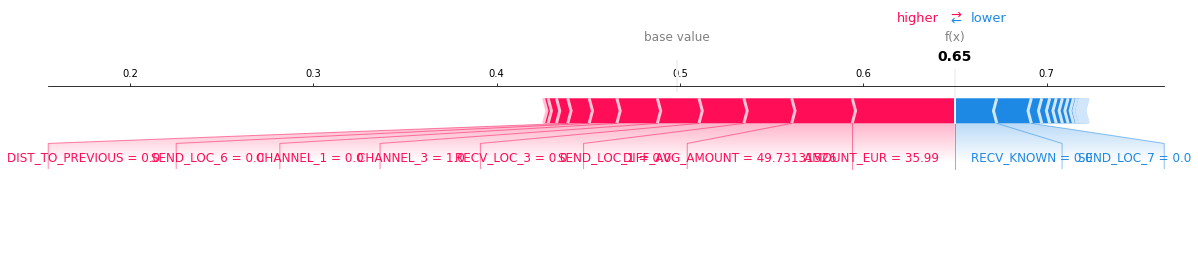

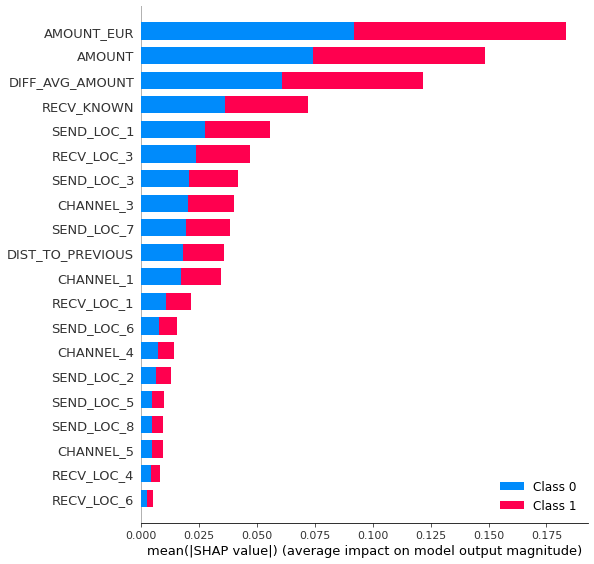

c) Global Feature Importance
None


None

e) Feature Impact
None


None

POSITIVE FEATURES
shap_pos_user_conf
0.1
NEGATIVE FEATURES
shap_neg_user_conf
1
suc_by_feature_impact
0.1
sub_by_gfi
0.1
suc_by_prototypes
0.9419999999999998
Prototypes to Analyze Similar Cases


Random Forest performance for the full training and testing dataset
Accuracy
0.8695652173913043
Precision
0.25
Recall
1.0
F1 Score
0.4
Analyzing Customer ID:  SEND_10
Analyzing Transactions:  [22]
8541    0
8542    0
8543    0
8544    0
8608    1
Name: FRAUD_LABEL, dtype: int64


Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).


Prediction:  [[0.33 0.67]]
index_to_check_switching_point:  1
a) Local Feature Importance


checking pos exlanations
final_exp_features
[('SEND_LOC_6=0', 0.07632529301392751), ('36.99 < AMOUNT <= 564.50', 0.07019977614067746), ('36.99 < AMOUNT_EUR <= 564.50', 0.06221717790321434), ('RECV_LOC_3=0', 0.053873404335284036), ('SEND_LOC_1=0', 0.041719510932775775), ('RECV_KNOWN=0', 0.037448570915191756), ('RECV_LOC_25=0', 0.03671851102975759), ('SEND_LOC_4=0', 0.031980422897433115), ('36.84 < DIFF_AVG_AMOUNT <= 564.26', 0.029377207351634186), ('RECV_LOC_8=0', 0.021254857463140108), ('CHANNEL_4=0', 0.020889485011089684), ('CHANNEL_1=0', 0.020359666966478653), ('CHANNEL_3=1', 0.01145053356442495), ('DIST_TO_PREVIOUS <= 0.00', 0.006042384731266397)]
Prediction After Change in LIME:  [[0.84 0.16]]
lime_user_conf
0.2
Anchor with data conditions and rules for predictions: AMOUNT > 36.99 AND RECV_KNOWN = 0 AND DIFF_AVG_AMOUNT > 36.84 AND DIST_TO_PREVIOUS <= 297.52
Precision: 1.00
Coverage: 0.15
suc_by_anchors_rules
1.0
Prediction After Change for Anchor:  [[0.55 0.45]]


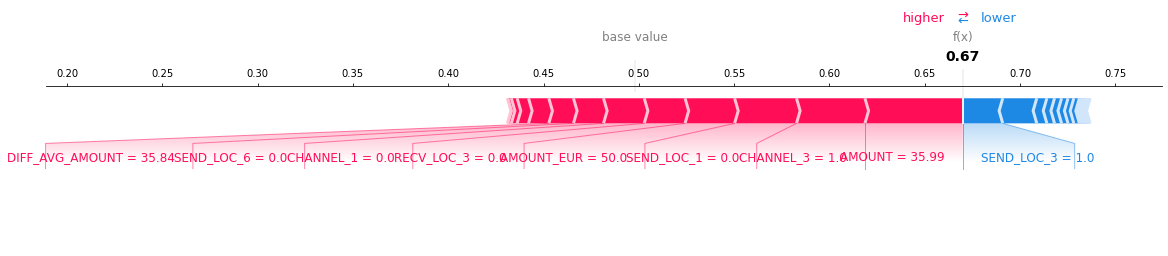

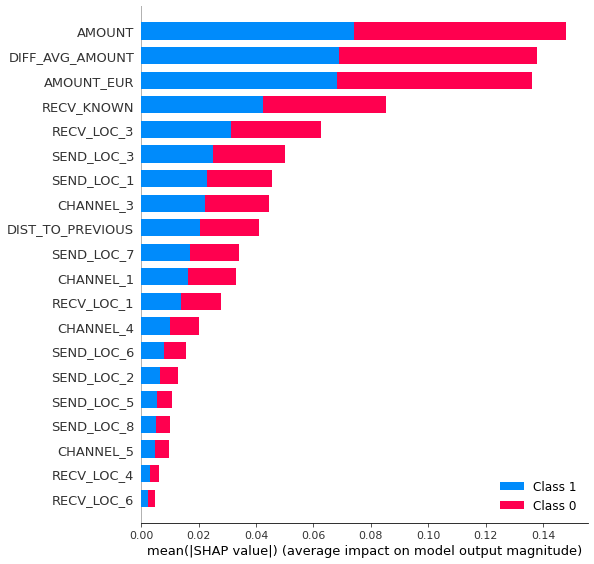

c) Global Feature Importance
None


None

e) Feature Impact
None


None

POSITIVE FEATURES
shap_pos_user_conf
0.2
NEGATIVE FEATURES
shap_neg_user_conf
1
suc_by_feature_impact
0.2
sub_by_gfi
0.1
suc_by_prototypes
0.9479999999999998
Prototypes to Analyze Similar Cases


Random Forest performance for the full training and testing dataset
Accuracy
0.8260869565217391
Precision
0.2
Recall
1.0
F1 Score
0.33333333333333337


In [17]:

if __name__ == '__main__':    
    main()
    